In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import datetime
from sklearn.preprocessing import StandardScaler

# 데이터 불러오기

In [3]:
weather_df_jeju = pd.read_csv("/content/drive/MyDrive/제주 에너지 이노베이터/data/weather_df_제주.csv")
weather_df_gosan = pd.read_csv("/content/drive/MyDrive/제주 에너지 이노베이터/data/weather_df_고산.csv")
weather_df_seongsan = pd.read_csv("/content/drive/MyDrive/제주 에너지 이노베이터/data/weather_df_성산.csv")
weather_df_seo = pd.read_csv("/content/drive/MyDrive/제주 에너지 이노베이터/data/weather_df_서귀포.csv")
solar_df = pd.read_csv("/content/drive/MyDrive/제주 에너지 이노베이터/data/solar_energy_df.csv")

In [4]:
solar_df

,date,hour,solar_energy
0,2021-01-01,1,0.00
1,2021-01-01,2,0.00
2,2021-01-01,3,0.00
3,2021-01-01,4,0.00
4,2021-01-01,5,0.01
...,...,...,...
17515,2022-12-31,20,7.83
17516,2022-12-31,21,7.22
17517,2022-12-31,22,3.75
17518,2022-12-31,23,0.66


In [5]:
merged_df_jeju = weather_df_jeju.merge(solar_df[['date', 'hour', 'solar_energy']], on=['date', 'hour'], how='left')
merged_df_jeju

,date,hour,WindDirection,WindSpeed,Cloud,Rainfall,Humidity,Temperature,Q12,Q13,Q_mean,solar_energy
0,2021-01-01,1,320.0,6.1,9.0,0.0,53.0,4.5,0.0,0.0,0.0,0.00
1,2021-01-01,2,320.0,5.6,9.0,0.0,58.0,4.3,0.0,0.0,0.0,0.00
2,2021-01-01,3,320.0,5.5,10.0,0.0,54.0,4.2,0.0,0.0,0.0,0.00
3,2021-01-01,4,320.0,5.4,10.0,0.0,52.0,4.3,0.0,0.0,0.0,0.00
4,2021-01-01,5,290.0,4.2,10.0,0.0,47.0,4.2,0.0,0.0,0.0,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
17515,2022-12-31,20,320.0,3.4,6.0,0.0,60.0,6.9,0.0,0.0,0.0,7.83
17516,2022-12-31,21,290.0,2.9,7.0,0.0,59.0,6.8,0.0,0.0,0.0,7.22
17517,2022-12-31,22,320.0,3.2,6.0,0.0,61.0,6.8,0.0,0.0,0.0,3.75
17518,2022-12-31,23,250.0,1.9,3.0,0.0,62.0,6.0,0.0,0.0,0.0,0.66


In [6]:
merged_df_jeju.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17520 entries, 0 to 17519
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           17520 non-null  object 
 1   hour           17520 non-null  int64  
 2   WindDirection  17518 non-null  float64
 3   WindSpeed      17518 non-null  float64
 4   Cloud          17502 non-null  float64
 5   Rainfall       17520 non-null  float64
 6   Humidity       17520 non-null  float64
 7   Temperature    17520 non-null  float64
 8   Q12            17520 non-null  float64
 9   Q13            17520 non-null  float64
 10  Q_mean         17520 non-null  float64
 11  solar_energy   17491 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 1.7+ MB


In [7]:
merged_df_jeju = merged_df_jeju.dropna()

<ipython-input-8-a4742e4d20a3>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df_jeju.corr(), annot=True, cmap=cmap)


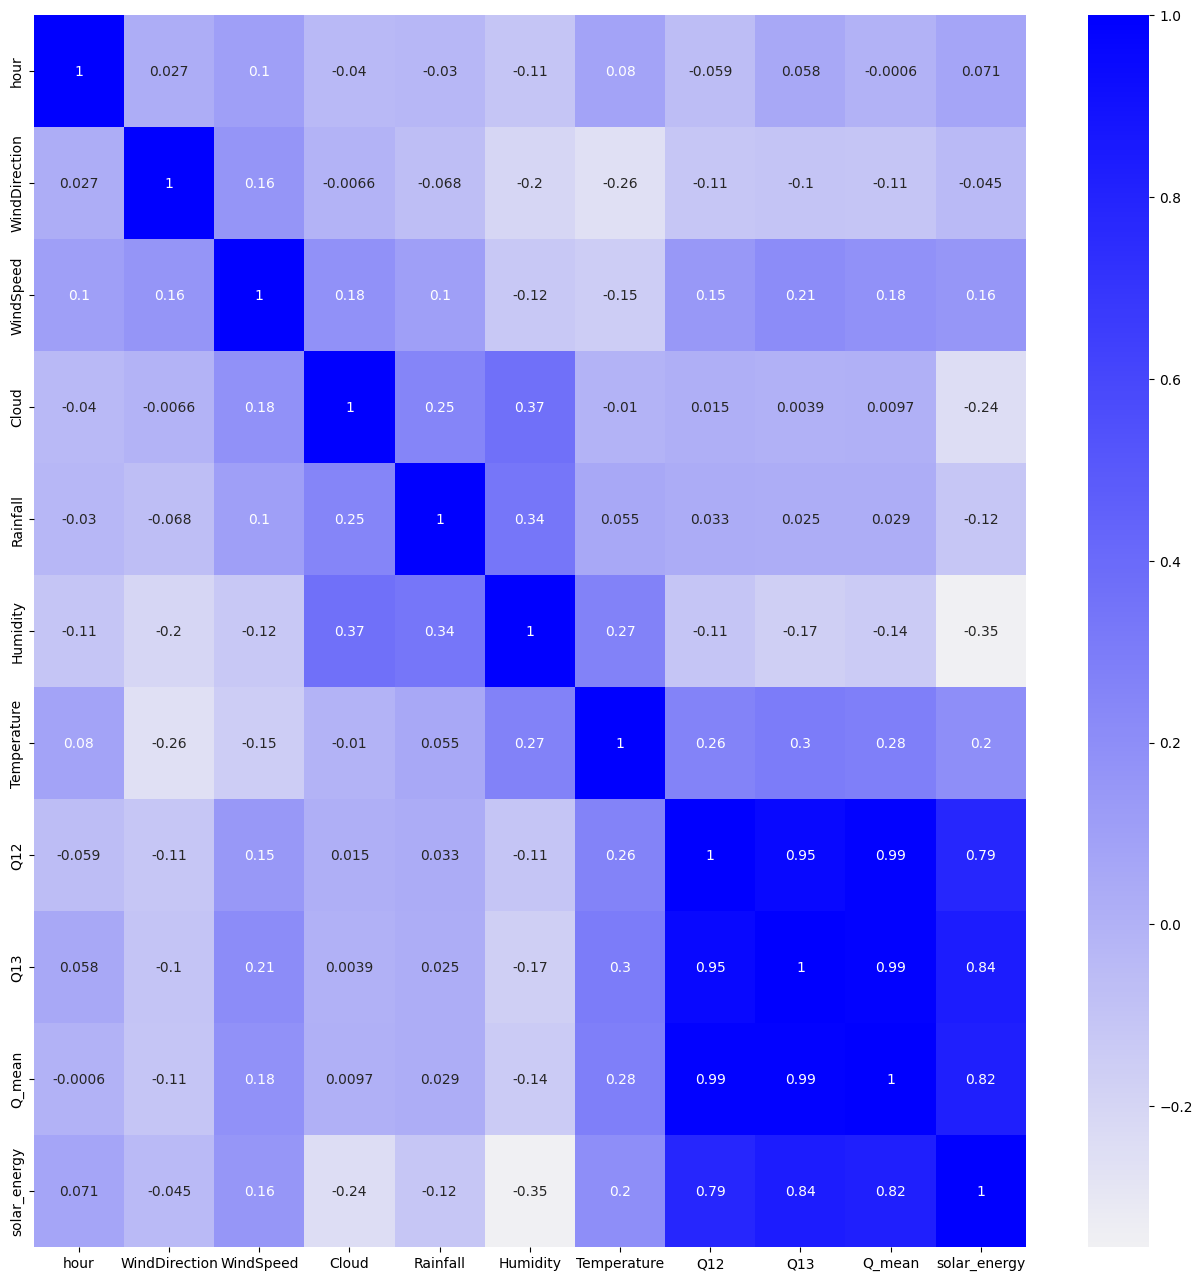

In [8]:
plt.figure(figsize=(16, 16))
cmap = sns.light_palette(color="b", as_cmap=True)
sns.heatmap(merged_df_jeju.corr(), annot=True, cmap=cmap)
plt.show()

# 모델링

In [9]:
import os
from tqdm import tqdm
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [10]:
# z - score scaling
ss = StandardScaler()

# 'solar_energy'(y)는 안했음
columns_to_scale = ['WindDirection', 'WindSpeed', 'Cloud', 'Rainfall', 'Humidity', 'Temperature', 'Q12', 'Q13', 'Q_mean']
merged_df_jeju[columns_to_scale] = ss.fit_transform(merged_df_jeju[columns_to_scale])

<ipython-input-10-ec9f24479957>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df_jeju[columns_to_scale] = ss.fit_transform(merged_df_jeju[columns_to_scale])


In [11]:
# features 우선 마음대로 해봄
features = merged_df_jeju.drop(['date', 'WindDirection', 'WindSpeed', 'Q12', 'Q_mean', 'solar_energy'], axis=1)
labels = merged_df_jeju['solar_energy']

In [12]:
class SunlightDataset(Dataset):
    def __init__(self, features, labels, window_size=2, step_size=1):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.labels = torch.tensor(labels.values, dtype=torch.float32)
        self.window_size = window_size
        self.step_size = step_size

    def __len__(self):
        total_steps = len(self.features) - self.window_size + 1
        # Calculate the number of complete windows that can be formed
        if total_steps > 0:
            return (total_steps + self.step_size - 1) // self.step_size
        else:
            return 0

    def __getitem__(self, index):
        start = index * self.step_size
        end = start + self.window_size

        return (self.features[start:end], self.labels[start:end])

In [13]:
col_name = list(features.columns)

In [14]:
col_name

['hour', 'Cloud', 'Rainfall', 'Humidity', 'Temperature', 'Q13']

In [15]:
features_train, features_val, labels_train, labels_val = train_test_split(features, labels, test_size=0.2, random_state=42)

In [16]:
train_dataset = SunlightDataset(features_train, labels_train)
val_dataset = SunlightDataset(features_val, labels_val)

In [17]:
len(train_dataset), len(val_dataset)

(13975, 3494)

In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [19]:
print(train_dataset[0])
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)

(tensor([[11.0000,  0.8053, -0.2429, -0.1263,  1.5072,  1.6152],
        [ 4.0000, -1.1678, -0.2429,  0.1485, -2.0403, -0.8091]]), tensor([98.5500,  0.7500]))
torch.Size([2, 6])
torch.Size([2])


In [20]:
train_features, train_labels = next(iter(train_loader))
print(train_features.shape)
print(train_labels.shape)

torch.Size([64, 2, 6])
torch.Size([64, 2])


In [21]:
!pip install transformers

In [22]:
import torch
import torch.nn as nn

try:
    from transformers.modeling_bert import BertConfig, BertEncoder, BertModel
except:
    from transformers.models.bert.modeling_bert import BertConfig, BertEncoder, BertModel

In [23]:
class LSTMwithAttn(nn.Module):

    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, num_heads=8, dropout=0.1, device='cpu'):
        super(LSTMwithAttn, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim
        self.dropout = dropout
        self.device = device

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        self.config = BertConfig(
            hidden_size=hidden_dim,
            num_hidden_layers=num_layers,
            num_attention_heads=num_heads,
            intermediate_size=hidden_dim,
            hidden_dropout_prob=dropout,
            attention_probs_dropout_prob=dropout,
        )
        self.encoder = BertEncoder(self.config)

        self.act = nn.SiLU()
        self.fc = nn.Linear(hidden_dim, output_dim)

        self.init_weights()


    def init_hidden_state(self, batch_size):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(self.device)
        return (h0, c0)


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)


    def generate_attn_mask(self, x):
        seq_len = x.size(1)
        attn_mask = torch.tril(torch.ones((seq_len, seq_len))).view(1, seq_len, seq_len).to(self.device)

        return attn_mask


    def forward(self, x):
        batch_size = x.size(0)

        h0, c0 = self.init_hidden_state(batch_size)

        output, (hidden, cell) = self.lstm(x, (h0, c0))

        output = output.contiguous().view(batch_size, -1, self.hidden_dim)

        # Attention Mask
        attn_mask = self.generate_attn_mask(x)
        extended_attn_mask = attn_mask[None, :, :, :].expand(batch_size, -1, -1, -1)
        extended_attn_mask = (1.0 - extended_attn_mask) * -10000.0

        encoder_outputs = self.encoder(output, attention_mask=extended_attn_mask)

        output = self.act(encoder_outputs.last_hidden_state)
        output = self.fc(output)

        return output

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [25]:
model = LSTMwithAttn(input_dim=6, hidden_dim=64, output_dim=1, num_layers=2, device=device)

In [26]:
model = model.to(device)

In [27]:
LEARNING_RATE = 0.001
EPOCHS = 100
WEIGHT_DECAY = 0.01
EARLY_STOPPING = 5

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [29]:
criterion = nn.MSELoss(reduction='mean')

In [30]:
train_losses = []
val_losses = []

loss = .0
best_val_loss = float('inf')
increasing_loss_count = 0

In [31]:
model.eval()

with torch.no_grad():
    for features, labels in val_loader:
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)

        _loss = criterion(outputs.squeeze(-1), labels)

        loss += _loss.item()

print(f'Initial Loss: {loss/len(val_loader):.4f}')

Initial Loss: 5774.0098


In [32]:
train_losses = []
val_losses = []

for i in range(EPOCHS):
    print("=" * 30)
    print(f"Current Epoch {i+1}")
    print("=" * 30)
    print("Training...")
    train_loss = .0

    model.train()
    for features, labels in tqdm(train_loader, leave=False):
        features = features.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(features)

        _loss = criterion(outputs.squeeze(-1), labels)
        _loss.backward()
        optimizer.step()

        train_loss += _loss.item()


    print("Evaluating...")
    val_loss = .0

    model.eval()

    for features, labels in tqdm(val_loader, leave=False):
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)

        _loss = criterion(outputs.squeeze(-1), labels)

        val_loss += _loss.item()

    train_losses += [train_loss/len(train_loader)]
    epoch_val_loss = val_loss/len(val_loader)
    val_losses += [epoch_val_loss]
    print(f"Epoch #{i+1}: [Training MSE/Evaluation MSE]: [{train_loss/len(train_loader):.4f}/{val_loss/len(val_loader):.4f}]")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        increasing_loss_count = 0
    else:
        increasing_loss_count += 1

    if increasing_loss_count >= EARLY_STOPPING:
        print("Early Stopping!")
        break

Current Epoch 1
Training...


Evaluating...


Epoch #1: [Training MSE/Evaluation MSE]: [5242.3019/4372.8864]
Current Epoch 2
Training...


Evaluating...


Epoch #2: [Training MSE/Evaluation MSE]: [3912.4361/2987.7891]
Current Epoch 3
Training...


Evaluating...


Epoch #3: [Training MSE/Evaluation MSE]: [2619.0591/1935.1373]
Current Epoch 4
Training...


Evaluating...


Epoch #4: [Training MSE/Evaluation MSE]: [1695.1327/1225.1760]
Current Epoch 5
Training...


Evaluating...


Epoch #5: [Training MSE/Evaluation MSE]: [1105.8305/786.2263]
Current Epoch 6
Training...


Evaluating...


Epoch #6: [Training MSE/Evaluation MSE]: [771.9757/571.5457]
Current Epoch 7
Training...


Evaluating...


Epoch #7: [Training MSE/Evaluation MSE]: [587.3205/453.9824]
Current Epoch 8
Training...


Evaluating...


Epoch #8: [Training MSE/Evaluation MSE]: [493.2736/394.6444]
Current Epoch 9
Training...


Evaluating...


Epoch #9: [Training MSE/Evaluation MSE]: [442.1232/365.0308]
Current Epoch 10
Training...


Evaluating...


Epoch #10: [Training MSE/Evaluation MSE]: [414.4531/348.1048]
Current Epoch 11
Training...


Evaluating...


Epoch #11: [Training MSE/Evaluation MSE]: [394.6719/336.9545]
Current Epoch 12
Training...


Evaluating...


Epoch #12: [Training MSE/Evaluation MSE]: [381.9619/329.5087]
Current Epoch 13
Training...


Evaluating...


Epoch #13: [Training MSE/Evaluation MSE]: [372.2589/327.3603]
Current Epoch 14
Training...


Evaluating...


Epoch #14: [Training MSE/Evaluation MSE]: [366.9165/326.8451]
Current Epoch 15
Training...


Evaluating...


Epoch #15: [Training MSE/Evaluation MSE]: [361.3902/324.7032]
Current Epoch 16
Training...


Evaluating...


Epoch #16: [Training MSE/Evaluation MSE]: [355.7923/324.7887]
Current Epoch 17
Training...


Evaluating...


Epoch #17: [Training MSE/Evaluation MSE]: [352.3690/318.7741]
Current Epoch 18
Training...


Evaluating...


Epoch #18: [Training MSE/Evaluation MSE]: [349.1107/316.2573]
Current Epoch 19
Training...


Evaluating...


Epoch #19: [Training MSE/Evaluation MSE]: [345.7708/315.7689]
Current Epoch 20
Training...


Evaluating...


Epoch #20: [Training MSE/Evaluation MSE]: [342.6503/311.5886]
Current Epoch 21
Training...


Evaluating...


Epoch #21: [Training MSE/Evaluation MSE]: [340.2187/313.2694]
Current Epoch 22
Training...


Evaluating...


Epoch #22: [Training MSE/Evaluation MSE]: [335.6187/310.7394]
Current Epoch 23
Training...


Evaluating...


Epoch #23: [Training MSE/Evaluation MSE]: [333.3253/311.2990]
Current Epoch 24
Training...


Evaluating...


Epoch #24: [Training MSE/Evaluation MSE]: [332.3019/312.1676]
Current Epoch 25
Training...


Evaluating...


Epoch #25: [Training MSE/Evaluation MSE]: [330.5061/308.2759]
Current Epoch 26
Training...


Evaluating...


Epoch #26: [Training MSE/Evaluation MSE]: [327.4286/307.5076]
Current Epoch 27
Training...


Evaluating...


Epoch #27: [Training MSE/Evaluation MSE]: [325.2429/306.2679]
Current Epoch 28
Training...


Evaluating...


Epoch #28: [Training MSE/Evaluation MSE]: [323.1586/307.9631]
Current Epoch 29
Training...


Evaluating...


Epoch #29: [Training MSE/Evaluation MSE]: [321.5630/309.9170]
Current Epoch 30
Training...


Evaluating...


Epoch #30: [Training MSE/Evaluation MSE]: [320.7945/308.8045]
Current Epoch 31
Training...


Evaluating...


Epoch #31: [Training MSE/Evaluation MSE]: [319.1928/306.5891]
Current Epoch 32
Training...


Evaluating...


Epoch #32: [Training MSE/Evaluation MSE]: [318.4444/307.2289]
Early Stopping!


In [33]:
%matplotlib inline

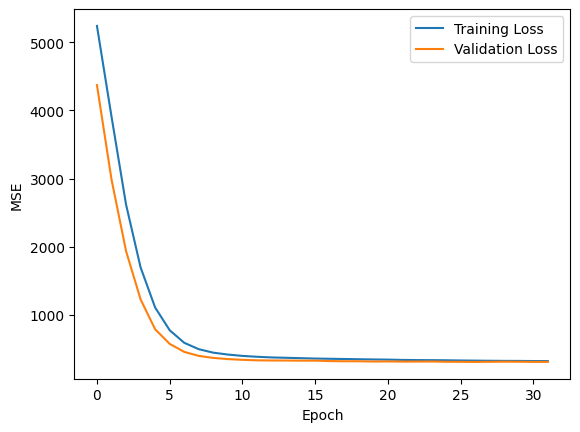

In [34]:
plt.plot(range(len(train_losses)), train_losses, label="Training Loss")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()

In [35]:
directory = 'models'
os.makedirs(directory, exist_ok=True)

torch.save(model.state_dict(), 'models/model.pt')

# 내일 데이터 불러오기

In [176]:
import pandas as pd
import urllib
import urllib.request
import json

In [177]:
servicekey = 's+fQ9LDUrt9xJ9LSIp0R4+gJBR7eOiUpRHNKXMb6gaV844FL4oI+OYVOY+MC2Bff+Iq9bQWFeWrktswAfBtkyg=='
url= 'http://apis.data.go.kr/1360000/VilageFcstInfoService_2.0/getVilageFcst'

queryParams = '?' + urllib.parse.urlencode(
    {
        urllib.parse.quote_plus('servicekey') : servicekey,
        urllib.parse.quote_plus('pageNo') : '1',
        urllib.parse.quote_plus('numOfRows') : '372',  # 12 * 31 = 372
       # 아님 12개 항목임
        urllib.parse.quote_plus('dataType') : 'JSON', # JSON, XML 두가지 포멧을 제공합니다.
        urllib.parse.quote_plus('base_date') : '20240212', # 예보 받을 날짜를 입력합니다. 최근 1일간의 자료만 제공합니다.
        urllib.parse.quote_plus('base_time') : '1700', # 예보 시간을 입력합니다. 2시부터 시작하여 3시간 단위로 입력 가능합니다.
        urllib.parse.quote_plus('nx') : '48', # 울산 태양광 발전소 x 좌표입니다. '기상청18_동네예보 조회서비스_오픈API활용가이드.zip'에 포함 된 excel파일을 통해 확인 가능합니다.
        urllib.parse.quote_plus('ny') : '36' # 울산 태양광 발전소 y 좌표입니다. '기상청18_동네예보 조회서비스_오픈API활용가이드.zip'에 포함 된 excel파일을 통해 확인 가능합니다.
    }
)

response = urllib.request.urlopen(url + queryParams).read()
response = json.loads(response)

In [178]:
import pandas as pd

# 새로운 데이터프레임을 생성
fcst_df = pd.DataFrame(columns=['Forecast_date', 'Forecast_hour', 'WindDirection', 'WindSpeed', 'Cloud', 'Rainfall', 'Humidity', 'Temperature'])

row_idx = 0  # row_idx 초기화

for data in response['response']['body']['items']['item']:
    fcst_df.loc[row_idx, 'Forecast_date'] = data['fcstDate']
    fcst_df.loc[row_idx, 'Forecast_hour'] = data['fcstTime']

    if data['category'] == 'REH':
        fcst_df.loc[row_idx, 'Humidity'] = float(data.get('fcstValue', 'NaN'))
    elif data['category'] == 'PCP':
        fcst_df.loc[row_idx, 'Rainfall'] = str(data.get('fcstValue', 'NaN'))
    elif data['category'] == 'TMP':
        fcst_df.loc[row_idx, 'Temperature'] = float(data.get('fcstValue', 'NaN'))
    elif data['category'] == 'SKY':
        fcst_df.loc[row_idx, 'Cloud'] = float(data.get('fcstValue', 'NaN'))
    elif data['category'] == 'VEC':
        fcst_df.loc[row_idx, 'WindDirection'] = float(data.get('fcstValue', 'NaN'))
    elif data['category'] == 'WSD':
        fcst_df.loc[row_idx, 'WindSpeed'] = float(data.get('fcstValue', 'NaN'))
        row_idx += 1  # 다음 행으로 이동

# train data와 양식 맞추기

In [179]:
# Forecast_date와 Forecast_hour 열을 datetime 형식으로 변환
fcst_df['Forecast_date'] = pd.to_datetime(fcst_df['Forecast_date'], format='%Y%m%d')
fcst_df['Forecast_hour'] = fcst_df['Forecast_hour'].astype(str).str.zfill(4)  # 시간을 4자리 문자열로 변환
fcst_df['Forecast_hour'] = fcst_df['Forecast_hour'].str[:2].astype(int)  # 앞의 2자리를 추출하여 정수로 변환

In [180]:
fcst_df = fcst_df.rename(columns={'Forecast_date': 'date', 'Forecast_hour': 'hour'})

# date가 '20240213'인 데이터만 추출하여 tomorrow_df에 저장
tomorrow_df = fcst_df[(fcst_df['date'] == '20240213')].copy()

In [181]:
tomorrow_df.replace('강수없음', float('nan'), inplace=True)

In [182]:
# Rainfall 열 값 변경
tomorrow_df['Rainfall'] = np.where((tomorrow_df['Rainfall'] > 0) & (tomorrow_df['Rainfall'] <= 3), 1, tomorrow_df['Rainfall'])
tomorrow_df['Rainfall'] = np.where(tomorrow_df['Rainfall'] > 3, 2, tomorrow_df['Rainfall'])

# NaN 값을 0으로 대체
tomorrow_df['Rainfall'].fillna(0, inplace=True)

# Cloud 값 보정
cloud_mapping = {1: 2, 2: 4, 3: 8, 4: 10}
tomorrow_df['Cloud'] = tomorrow_df['Cloud'].map(cloud_mapping)

# hour 값 0~23 을 1~24로 수정
tomorrow_df['hour'] = tomorrow_df['hour'] + 1

tomorrow_df

,date,hour,WindDirection,WindSpeed,Cloud,Rainfall,Humidity,Temperature
6,2024-02-13,1,181.0,4.6,2,0.0,75.0,8.0
7,2024-02-13,2,184.0,4.9,2,0.0,75.0,8.0
8,2024-02-13,3,186.0,5.1,2,0.0,75.0,8.0
9,2024-02-13,4,186.0,5.0,2,0.0,75.0,9.0
10,2024-02-13,5,187.0,4.9,2,0.0,75.0,9.0
11,2024-02-13,6,188.0,4.8,2,0.0,75.0,8.0
12,2024-02-13,7,191.0,4.8,2,0.0,80.0,9.0
13,2024-02-13,8,193.0,4.8,2,0.0,80.0,8.0
14,2024-02-13,9,195.0,5.0,2,0.0,80.0,10.0
15,2024-02-13,10,198.0,5.8,2,0.0,80.0,12.0


In [183]:
an = [1.000110,0.034221,0.000719]
bn = [0,0.001280,0.000077]
cn = [0.006918,-0.399912,-0.006758,-0.002697]
dn = [0,0.070257,0.000907,0.000148]


S = 1367 #solar constant
L = 33.3 #latitude
L_rad = np.deg2rad(L) #latitude를 rad으로 변환

tomorrow_df['date'] = pd.to_datetime(tomorrow_df['date'])
d = tomorrow_df['date'].dt.dayofyear
t = 2*np.pi*d/365

In [184]:
LN = datetime.datetime(2024, 2, 9, 12, 0, 0) # local noon time

In [185]:
# sun-earth distance  : r0 값을 알 수 없어서, a로 근사한 식을 이용함
r0_r2 = np.zeros(t.shape)
for i in range(0,3) :
    r0_r2 = r0_r2+an[i]*np.cos(i*t)+bn[i]*np.sin(i*t)

# declination angle
delta_rad = np.zeros(t.shape)
for i in range(0,4) :
    delta_rad = delta_rad+cn[i]*np.cos(i*t)+dn[i]*np.sin(i*t)

In [186]:
# Solar insolation for hour gap
# Q12는 태양 남중 12시로 가정한거고, Q13은 남중 13시로 가정한검니당
Q = np.zeros(t.shape)
gap = np.pi/12
tomorrow_df['Q12'] = S*r0_r2*((np.sin(L_rad)*np.sin(delta_rad))+((24/np.pi)*np.cos(L_rad)*np.cos(delta_rad)*np.sin(np.pi/24)*np.cos((tomorrow_df.hour-12)*gap)))
tomorrow_df['Q12'] = tomorrow_df['Q12'].apply(lambda x: max(0, x))
tomorrow_df['Q13'] = S*r0_r2*((np.sin(L_rad)*np.sin(delta_rad))+((24/np.pi)*np.cos(L_rad)*np.cos(delta_rad)*np.sin(np.pi/24)*np.cos((tomorrow_df.hour-13)*gap)))
tomorrow_df['Q13'] = tomorrow_df['Q13'].apply(lambda x: max(0, x))
tomorrow_df['Q_mean'] = (tomorrow_df['Q12']+tomorrow_df['Q13'])/2

In [187]:
tomorrow_df

,date,hour,WindDirection,WindSpeed,Cloud,Rainfall,Humidity,Temperature,Q12,Q13,Q_mean
6,2024-02-13,1,181.0,4.6,2,0.0,75.0,8.0,0.000000,0.000000,0.000000
7,2024-02-13,2,184.0,4.9,2,0.0,75.0,8.0,0.000000,0.000000,0.000000
8,2024-02-13,3,186.0,5.1,2,0.0,75.0,8.0,0.000000,0.000000,0.000000
9,2024-02-13,4,186.0,5.0,2,0.0,75.0,9.0,0.000000,0.000000,0.000000
10,2024-02-13,5,187.0,4.9,2,0.0,75.0,9.0,0.000000,0.000000,0.000000
11,2024-02-13,6,188.0,4.8,2,0.0,75.0,8.0,0.000000,0.000000,0.000000
12,2024-02-13,7,191.0,4.8,2,0.0,80.0,9.0,116.552620,0.000000,58.276310
13,2024-02-13,8,193.0,4.8,2,0.0,80.0,8.0,390.845307,116.552620,253.698963
14,2024-02-13,9,195.0,5.0,2,0.0,80.0,10.0,626.385777,390.845307,508.615542
15,2024-02-13,10,198.0,5.8,2,0.0,80.0,12.0,807.122337,626.385777,716.754057


In [188]:
# columns_to_scale 정의
columns_to_scale = ['WindDirection', 'WindSpeed', 'Cloud', 'Rainfall', 'Humidity', 'Temperature', 'Q12', 'Q13', 'Q_mean']

# test 세트에도 동일한 scaling 적용
tomorrow_df[columns_to_scale] = ss.transform(tomorrow_df[columns_to_scale])

In [189]:
tomorrow_df.describe()

,hour,WindDirection,WindSpeed,Cloud,Rainfall,Humidity,Temperature,Q12,Q13,Q_mean
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,12.500000,0.077424,1.092315,-0.087284,-0.242925,0.185692,-0.572287,-0.174786,-0.174733,-0.177002
std,7.071068,0.101671,0.402942,0.953797,0.000000,0.398533,0.413027,0.846512,0.846556,0.844381
min,1.000000,-0.100431,0.576765,-1.167831,-0.242925,-0.401138,-1.129112,-0.809135,-0.809115,-0.819508
25%,6.750000,-0.000595,0.834540,-1.167831,-0.242925,-0.143506,-1.007623,-0.809135,-0.809115,-0.819508
50%,12.500000,0.063743,0.929510,0.523460,-0.242925,0.285882,-0.400177,-0.809135,-0.809115,-0.752273
75%,18.250000,0.161360,1.377224,0.523460,-0.242925,0.629392,-0.157199,0.617866,0.617960,0.474161
max,24.000000,0.236792,1.879207,1.087224,-0.242925,0.629392,-0.035710,1.376729,1.376862,1.349754


In [190]:
testdata = tomorrow_df.drop(['date', 'WindDirection', 'WindSpeed', 'Q12', 'Q_mean'], axis=1)

# 다음날 값 예측

In [191]:
# Load the model

model.load_state_dict( torch.load('models/model.pt') )
model.to(device)

LSTMwithAttn(
  (lstm): LSTM(6, 64, num_layers=2, batch_first=True)
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-1): 2 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=64, out_features=64, bias=True)
            (key): Linear(in_features=64, out_features=64, bias=True)
            (value): Linear(in_features=64, out_features=64, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=64, out_features=64, bias=True)
            (LayerNorm): LayerNorm((64,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
        (intermediate): BertIntermediate(
          (dense): Linear(in_features=64, out_features=64, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): BertOutput(
          (dense): Linear(in_features=

In [192]:
testdata

,hour,Cloud,Rainfall,Humidity,Temperature,Q13
6,1,-1.167831,-0.242925,0.285882,-1.129112,-0.809115
7,2,-1.167831,-0.242925,0.285882,-1.129112,-0.809115
8,3,-1.167831,-0.242925,0.285882,-1.129112,-0.809115
9,4,-1.167831,-0.242925,0.285882,-1.007623,-0.809115
10,5,-1.167831,-0.242925,0.285882,-1.007623,-0.809115
11,6,-1.167831,-0.242925,0.285882,-1.129112,-0.809115
12,7,-1.167831,-0.242925,0.629392,-1.007623,-0.809115
13,8,-1.167831,-0.242925,0.629392,-1.129112,-0.543576
14,9,-1.167831,-0.242925,0.629392,-0.886134,0.081336
15,10,-1.167831,-0.242925,0.629392,-0.643155,0.617960


In [193]:
features_test = testdata
labels_test = pd.DataFrame({'label': [0] * len(testdata)})
test_dataset = SunlightDataset(features_test, labels_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [194]:
# get number of rows in testdata
num_test = len(features_test)
num_test

24

In [195]:
next(iter(test_loader))[0].shape

torch.Size([1, 2, 6])

In [196]:
y_pred = [[] for _ in range(num_test)]
len(y_pred)

24

In [197]:
# test phase
model.eval()

with torch.no_grad():
    for i, (features, labels) in enumerate(test_loader):
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features).squeeze(-1)
        outputs[outputs < 3] = 0

        for seq_idx in range(outputs.shape[-1]):
            y_pred[i + seq_idx].append(outputs[:,seq_idx].item())

In [198]:
y_pred = [sum(y_pred[i]) / len(y_pred[i]) for i in range(len(y_pred))]

In [199]:
y_pred

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.529135704040527,
 59.69935607910156,
 119.90898132324219,
 127.88987731933594,
 141.12932586669922,
 141.7287368774414,
 69.70762634277344,
 59.206172943115234,
 77.2107048034668,
 26.563661575317383,
 7.911825180053711,
 3.512577772140503,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [200]:
y_pred_pd = pd.DataFrame(y_pred)
y_pred_pd.to_csv('solar.csv', index=False)